In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns 

from scipy import stats
import math

from datetime import datetime, timedelta

from statsmodels.stats.proportion import proportions_ztest

### Создание датасетов

In [2]:
history = pd.read_csv('funnel_history_.csv')
history

,user_id,event_name,event_dt,dt,region
0,--014ca35_b7,login,2020-05-09 04:20:12,2020-05-09,North America
1,--014ca35_b7,tutorial_completed,2020-05-09 04:20:13,2020-05-09,North America
2,--014ca35_b7,tuturial_started,2020-05-09 04:20:11,2020-05-09,North America
3,--0424774bcb,login,2020-05-30 07:23:03,2020-05-30,CIS
4,--0424774bcb,tutorial_completed,2020-05-30 07:23:05,2020-05-30,CIS
...,...,...,...,...,...
80249,fff7d81ca3_5,tutorial_completed,2020-05-31 18:55:50,2020-05-31,Africa
80250,fff7d81ca3_5,tuturial_started,2020-05-31 18:55:47,2020-05-31,Africa
80251,fff88bbb3_c8,login,2020-05-28 13:14:36,2020-05-28,SEA
80252,fff88bbb3_c8,tutorial_completed,2020-05-28 13:14:38,2020-05-28,SEA


In [3]:
new_users = history.groupby(by='dt').agg({'user_id': 'nunique'})
new_users.mean()

user_id    985.806452
dtype: float64

In [4]:
history_event = history.groupby(by='event_name').agg({'user_id': 'nunique'}).sort_values('user_id', ascending = False)
history_event['%'] = history_event['user_id'] / history_event['user_id'][0]
history_event.style.format({'%' : '{:.2%}'})

,user_id,%
event_name,,
login,30560,100.00%
tuturial_started,27408,89.69%
tutorial_completed,22286,72.93%


Рассчитаю необходимую длительность A/B-теста, считая, что:

Уровень значимости (alpha) и мощность (beta) равны 0.05 и 0.8;
Ваши коллеги ожидают, что новый туториал повысит вероятность прохождения обучения на 3.8% (0.038).
Не забудь учесть сезонность;

In [5]:
# Расчет длительности теста
def get_sample_size(mean, # среднее метрики
                    std, # среднеквадратическое отклонение (СКО) метрики
                    relative_practical_significance, # минимальный эффект - процент изменений среднего метрики, который мы хотим обнаружить
                    alpha, # уровень значимости (вероятность обнаружить эффект случайно)
                    power, # мощность (вероятность Не отбросить случайно реально существующий эффект)
                   ):
    z = stats.norm.ppf(1 - alpha / 2) + abs(stats.norm.ppf(1 - power))
    d = mean * relative_practical_significance
    
    return math.ceil(2 * ((std * z / d) ** 2))

In [6]:
alpha = 0.05
power = 0.8
alpha, power

(0.05, 0.8)

In [7]:
p = len(history.query('event_name == "tutorial_completed"')['user_id'].unique()) / len(history.query('event_name == "login"')['user_id'].unique())
conversion_mean = p
conversion_std = np.sqrt(p * (1 - p))

print(f'Средняя конверсия: {conversion_mean:.2%}, СКО конверсии: {conversion_std:.2f}')

Средняя конверсия: 72.93%, СКО конверсии: 0.44


In [8]:
# Рассчитаю необходимую длительность A/B-теста
sample_size = get_sample_size(conversion_mean, conversion_std, 0.038, alpha, power)
sample_size 

4037

Число дней найдем по формуле:нужный_размер_выборки / среднее_число_новых_пользователей_в_день
Поскольку групп в тесте у нас 2, то нам нужно будет умножить результат на 2

In [9]:
# среднее число новых пользователей в день
new_users = history.groupby(by='dt').agg({'user_id': 'nunique'})
new_daily_users = new_users.mean()[0]

In [10]:
desired_sample_size = sample_size * 2 # нужный размер выборки для двух групп
print(f'Среднее число новых пользователей в день: {new_daily_users:.0f}, нужный размер выборки: {desired_sample_size}')

Среднее число новых пользователей в день: 986, нужный размер выборки: 8074


In [11]:
test_days_num = desired_sample_size / new_daily_users
print(f'На проведение теста потребуется: {test_days_num:.0f} дней')

На проведение теста потребуется: 8 дней


In [12]:
# Учитываем сезонность потребность на проведение теста увеличиваем до 14 дней

### Оценка корректности проведения теста

Тест решено было запустить 14.06.2020. Сегодня 19.06.2020, тест идет уже 5 дней. Оцените корректность проведения теста. С помощью статистического теста проверьте, попадают ли пользователи в с равной вероятностью в обе тестовые группы.

In [13]:
participants = pd.read_csv('participants_run_.csv')
participants

,user_id,test_name,test_group
0,-5dabb4f564d,new_tutorial_test,A
1,9d335_2101b0,new_tutorial_test,A
2,29_1_-d06009,new_tutorial_test,A
3,4-11cdb_323_,new_tutorial_test,A
4,09a-1df--3-8,new_tutorial_test,A
...,...,...,...
2830,da548a441d78,new_tutorial_test,B
2831,4df97d74a826,new_tutorial_test,B
2832,49-8-d102058,new_tutorial_test,B
2833,8-512dcc03-6,new_tutorial_test,B


In [14]:
participants['test_name'].unique()

array(['new_tutorial_test'], dtype=object)

In [15]:
participants_ab = participants.groupby(by=['test_name','test_group']).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'Участники'})
participants_ab['%'] = (participants_ab['Участники'] / participants_ab['Участники'].sum()).round(2)
participants_ab

Участники     %
test_name         test_group                 
new_tutorial_test A                1368  0.48
                  B                1467  0.52

In [16]:
a_users = participants.query('test_group == "A"').shape[0]
all_users = participants.shape[0]

alpha = 0.05
p_value = proportions_ztest(a_users, all_users, value = 0.5)[1]
print(f'p-value: {p_value}')
if p_value >= alpha:
    print('Нулевая гипотеза не отвергается: вероятность попасть в группу A составляет 50%')
else:
     print('Нулевая гипотеза отвергается: вероятность попасть в группу A не составляет 50%')

p-value: 0.06281848165225283
Нулевая гипотеза не отвергается: вероятность попасть в группу A составляет 50%


#### Видим, что вероятность попасть в группу B составляет более 50%, отличие небольшое, попадаем в доверительный интервал. Продолжаем тест 

In [17]:
# Теперь проверим есть ли у нас участники попавшие сразу в две группы
participants.groupby('user_id').agg({'test_group': 'nunique'}).query('test_group > 1')

,test_group
user_id,


Таких пользователей не оказалось

In [18]:
# Проверим, не пора ли останавливать тест
print(f'Ожидаемое число пользователей: {desired_sample_size}, Текущее число пользователей: {participants.count()[0]}')

Ожидаемое число пользователей: 8074, Текущее число пользователей: 2835


Тест останавливать еще рано, можем пропустить полезный эффект при проведении стат-тестов. Продолжаем собирать данные

### Анализ результатов теста

In [19]:
test_events = pd.read_csv('funnel_test_.csv')
test_events

,user_id,event_name,event_dt,test_group
0,--0879c8c638,login,2020-06-22 07:53:05,A
1,--0879c8c638,tutorial_completed,2020-06-22 07:53:02,A
2,--0879c8c638,tuturial_started,2020-06-22 07:53:12,A
3,--10-567_cd0,login,2020-06-26 13:14:00,A
4,--10-567_cd0,tuturial_started,2020-06-26 13:14:02,A
...,...,...,...,...
22440,fff34d_b25d7,login,2020-06-14 01:16:34,B
22441,fff34d_b25d7,tutorial_completed,2020-06-14 01:16:38,B
22442,fff34d_b25d7,tuturial_started,2020-06-14 01:16:37,B
22443,fffa52af06d-,login,2020-06-19 10:48:31,B


In [20]:
print(f'ожидаемое число пользователей: {desired_sample_size}, Текущее число пользователей: {test_events["user_id"].nunique()}')

ожидаемое число пользователей: 8074, Текущее число пользователей: 8551


In [21]:
test_events.groupby(by = 'test_group').agg({'user_id': 'nunique'})

,user_id
test_group,
A,4226
B,4325


In [22]:
# уровень значимости
alpha = 0.05

In [23]:
test_new_users = test_events.groupby(by = 'test_group').agg({'user_id': 'nunique'})
test_new_users['conversion'] = (test_new_users['user_id'] / test_new_users['user_id'].sum()).round(2)
test_new_users

,user_id,conversion
test_group,,
A,4226,0.49
B,4325,0.51


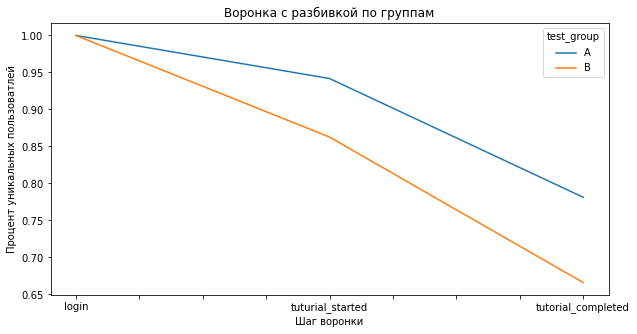

In [24]:
report = test_events.pivot_table(index = 'event_name', columns = 'test_group', values = 'user_id', aggfunc = 'nunique')
report = report.sort_values(by = 'A', ascending = False)
report['A'] = report['A'] / report['A'].login
report['B'] = report['B'] / report['B'].login
report.plot(figsize=(10,5))
plt.xlabel('Шаг воронки'), plt.ylabel('Процент уникальных пользоватлей'), plt.title('Воронка с разбивкой по группам');

In [25]:
history_event_ = test_events.pivot_table(index = 'event_name', columns = 'test_group', values = 'user_id', aggfunc = 'nunique')
history_event_ = history_event_.sort_values(by = 'A', ascending = False)
history_event_['%_A'] = history_event_['A'] / history_event_['A'][0]
history_event_['%_B'] = history_event_['B'] / history_event_['B'][0]
history_event_.style.format({'%_A' : '{:.2%}', '%_B' : '{:.2%}'})

test_group,A,B,%_A,%_B
event_name,,,,
login,4226,4325,100.00%,100.00%
tuturial_started,3980,3731,94.18%,86.27%
tutorial_completed,3302,2881,78.14%,66.61%


In [26]:
print(f'Конверсия после проведеняи теста: {history_event_["%_A"][2]}, Конверсия до проведеняи теста: {history_event["%"][2]}')

Конверсия после проведеняи теста: 0.7813535257927118, Конверсия до проведеняи теста: 0.7292539267015706


Конверсия прохождения туториала до проведения A/B теста была 73%. Ожидалось, что тест повысит конверсию прохождения туториала на 3.8 %. Для пользователей группы A, для которых проводился тест конверсия увеличилась на чуть больше 4 %

In [27]:
report = test_events.pivot_table(index = 'test_group', columns = 'event_name', values = 'user_id', aggfunc = 'nunique')[['login', 'tuturial_started', 'tutorial_completed']]
report

event_name,login,tuturial_started,tutorial_completed
test_group,,,
A,4226,3980,3302
B,4325,3731,2881


In [28]:
count = list(report['tutorial_completed'].values)
nobs = list(report['login'].values)

p_value = proportions_ztest(count, nobs, value = 0)[1]
print(f'p-value: {p_value}')
if p_value >= alpha:
    print('Нулеая гипотеза не отвергается: между группами A и B нет различия в % завершении туториала.')
else:
    print('Нулеая гипотеза отвергается: между группами A и B есть различия в % завершении туториала.')

p-value: 1.1152854995855214e-32
Нулеая гипотеза отвергается: между группами A и B есть различия в % завершении туториала.
